<a href="https://colab.research.google.com/github/tkurewa/Recommendation-Engine/blob/main/ZSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")


In [35]:
# Load dataset
file_path = "/content/drive/MyDrive/Data_ZSE.csv"

dataset = pd.read_csv(file_path,index_col='Month')

# Display basic dataset info
print("Dataset Information:")
print(dataset.info())

# Display the first few rows
print("\nDataset Head:")
print(dataset.head())

# Check for missing values
print("\nMissing Values:")
print(dataset.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, Jan-19 to Dec-23
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Stock_Price         60 non-null     float64
 1   Inflation           60 non-null     float64
 2   Interest_Rate       60 non-null     int64  
 3   Sentiment_Score     60 non-null     float64
 4   Future_Stock_Price  60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.8+ KB
None

Dataset Head:
        Stock_Price  Inflation  Interest_Rate  Sentiment_Score  \
Month                                                            
Jan-19       0.0816      10.75             15        -0.153056   
Feb-19       0.0172       1.70             15         0.921544   
Mar-19       0.0143       4.40             15         0.119539   
Apr-19       0.0157       5.50             15        -0.870028   
May-19       0.0219      12.54             15         0.680798 

In [36]:
# Summary statistics
print("\nSummary Statistics:")
print(dataset.describe())



Summary Statistics:
       Stock_Price  Inflation  Interest_Rate  Sentiment_Score  \
count    60.000000  60.000000      60.000000        60.000000   
mean      3.101238  40.790833      80.083333        -0.039884   
std       5.707289  22.802255      63.622907         0.381991   
min       0.014300 -11.000000      15.000000        -0.870028   
25%       0.075450  31.160000      35.000000        -0.239582   
50%       0.761600  39.000000      50.000000        -0.149541   
75%       2.443175  62.225000     140.000000         0.055598   
max      23.890000  82.460000     200.000000         0.986544   

       Future_Stock_Price  
count           60.000000  
mean             3.506445  
std              6.319499  
min              0.014300  
25%              0.117225  
50%              0.783850  
75%              2.537950  
max             24.394000  


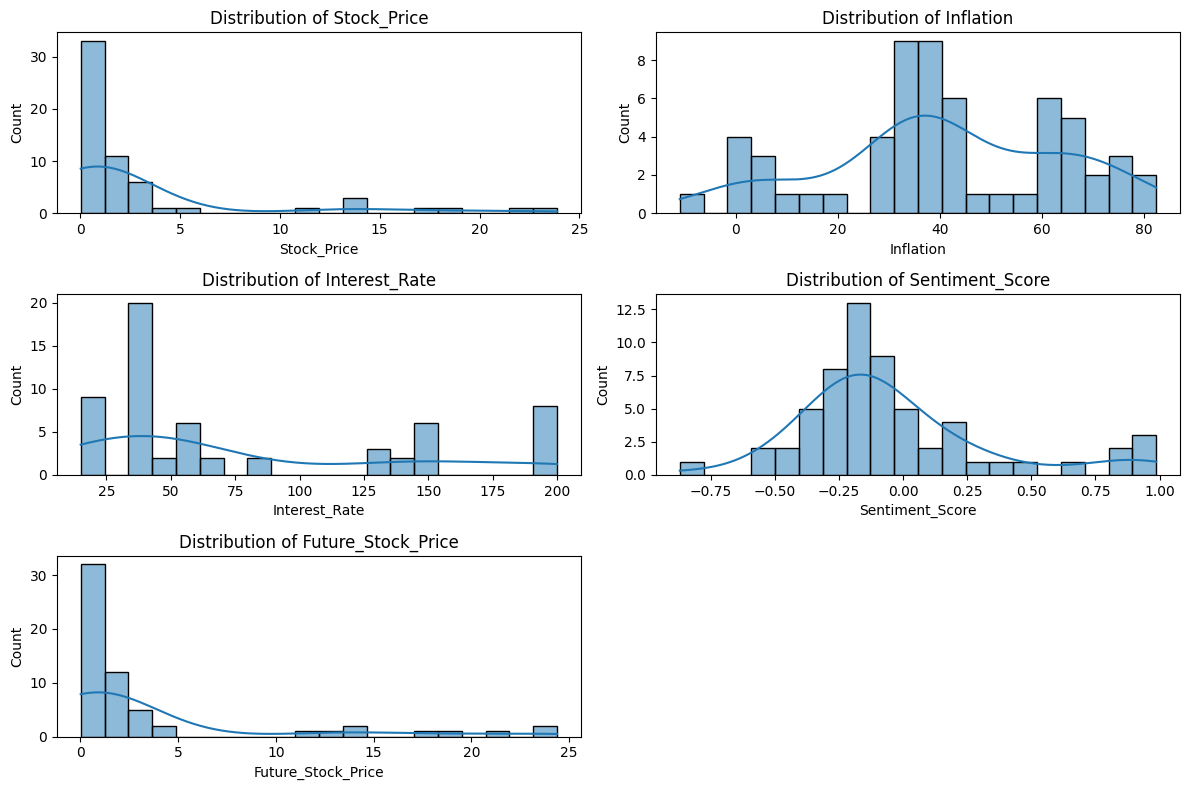

In [37]:
# Visualizing feature distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(['Stock_Price', 'Inflation', 'Interest_Rate', 'Sentiment_Score', 'Future_Stock_Price']):
    plt.subplot(3, 2, i + 1)
    sns.histplot(dataset[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


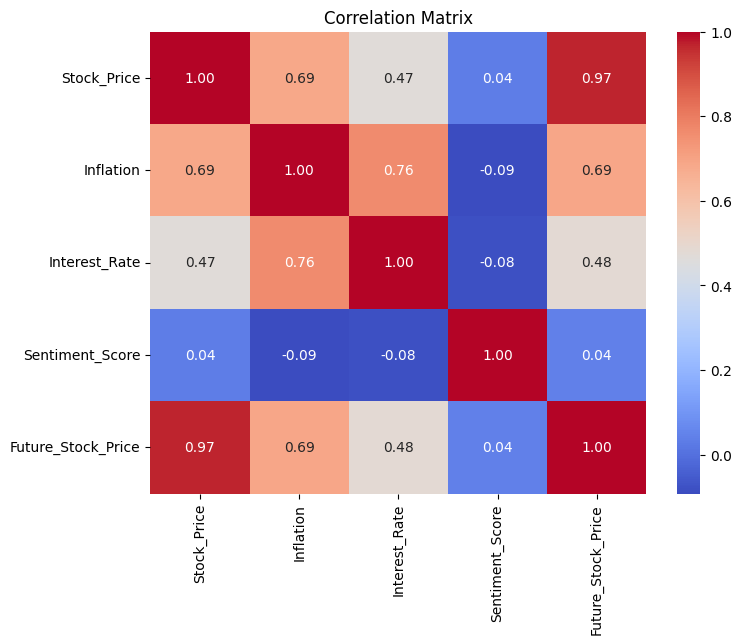

In [38]:
# Correlation matrix
corr_matrix = dataset.corr()

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [39]:
# Features and target variable
X = dataset[['Stock_Price', 'Inflation', 'Interest_Rate', 'Sentiment_Score']]
y = dataset['Future_Stock_Price']

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and testing sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [40]:
# SVR with GridSearchCV for hyperparameter tuning
svr = SVR()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svr_grid = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)

# Best SVR model
svr_best = svr_grid.best_estimator_
svr_val_pred = svr_best.predict(X_val)
svr_test_pred = svr_best.predict(X_test)


In [41]:
# Random Forest with hyperparameter tuning
rf = RandomForestRegressor()
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Best Random Forest model
rf_best = rf_grid.best_estimator_
rf_val_pred = rf_best.predict(X_val)
rf_test_pred = rf_best.predict(X_test)


In [42]:
# Gradient Boosting Regressor with hyperparameter tuning
gbm = GradientBoostingRegressor()
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
gbm_grid = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error')
gbm_grid.fit(X_train, y_train)

# Best GBM model
gbm_best = gbm_grid.best_estimator_
gbm_val_pred = gbm_best.predict(X_val)
gbm_test_pred = gbm_best.predict(X_test)


In [43]:
# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), batch_size=32, epochs=10, verbose=1)

# Predictions
lstm_val_pred = lstm_model.predict(X_val_lstm).flatten()
lstm_test_pred = lstm_model.predict(X_test_lstm).flatten()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - loss: 45.3461 - val_loss: 92.5837
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 41.0889 - val_loss: 92.2461
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 50.9609 - val_loss: 91.9531
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 50.8148 - val_loss: 91.6227
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 49.5155 - val_loss: 91.2465
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 50.3830 - val_loss: 90.8111
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 44.1139 - val_loss: 90.3012
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 46.7635 - val_loss: 89.6904
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 48.0397 - val_loss: 88.9570
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 50.8138 - val_loss: 88.1091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [44]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, MAPE: {mape:.2%}")

# Evaluate all models
print("Validation Results:")
evaluate_model(y_val, svr_val_pred, "SVR")
evaluate_model(y_val, rf_val_pred, "Random Forest")
evaluate_model(y_val, gbm_val_pred, "Gradient Boosting")
evaluate_model(y_val, lstm_val_pred, "LSTM")

print("\nTesting Results:")
evaluate_model(y_test, svr_test_pred, "SVR")
evaluate_model(y_test, rf_test_pred, "Random Forest")
evaluate_model(y_test, gbm_test_pred, "Gradient Boosting")
evaluate_model(y_test, lstm_test_pred, "LSTM")


Validation Results:
SVR - MAE: 1.60, RMSE: 3.02, R²: 0.85, MAPE: 497.58%
Random Forest - MAE: 1.41, RMSE: 2.38, R²: 0.91, MAPE: 84.60%
Gradient Boosting - MAE: 1.00, RMSE: 1.99, R²: 0.94, MAPE: 228.24%
LSTM - MAE: 5.32, RMSE: 9.39, R²: -0.42, MAPE: 211.80%

Testing Results:
SVR - MAE: 0.50, RMSE: 0.64, R²: 0.98, MAPE: 1315.52%
Random Forest - MAE: 0.62, RMSE: 1.06, R²: 0.94, MAPE: 413.72%
Gradient Boosting - MAE: 0.68, RMSE: 1.15, R²: 0.93, MAPE: 827.23%
LSTM - MAE: 2.22, RMSE: 4.65, R²: -0.17, MAPE: 505.88%


In [45]:
import joblib
import os
from tensorflow.keras.models import load_model

# Create a directory to store the saved models
os.makedirs("saved_models", exist_ok=True)

# Save SVR model
joblib.dump(svr_best, "saved_models/svr_model.pkl")

# Save Random Forest model
joblib.dump(rf_best, "saved_models/random_forest_model.pkl")

# Save Gradient Boosting model
joblib.dump(gbm_best, "saved_models/gbm_model.pkl")

# Save LSTM model
lstm_model.save("saved_models/lstm_model.h5")

print("Models saved successfully!")


Models saved successfully!


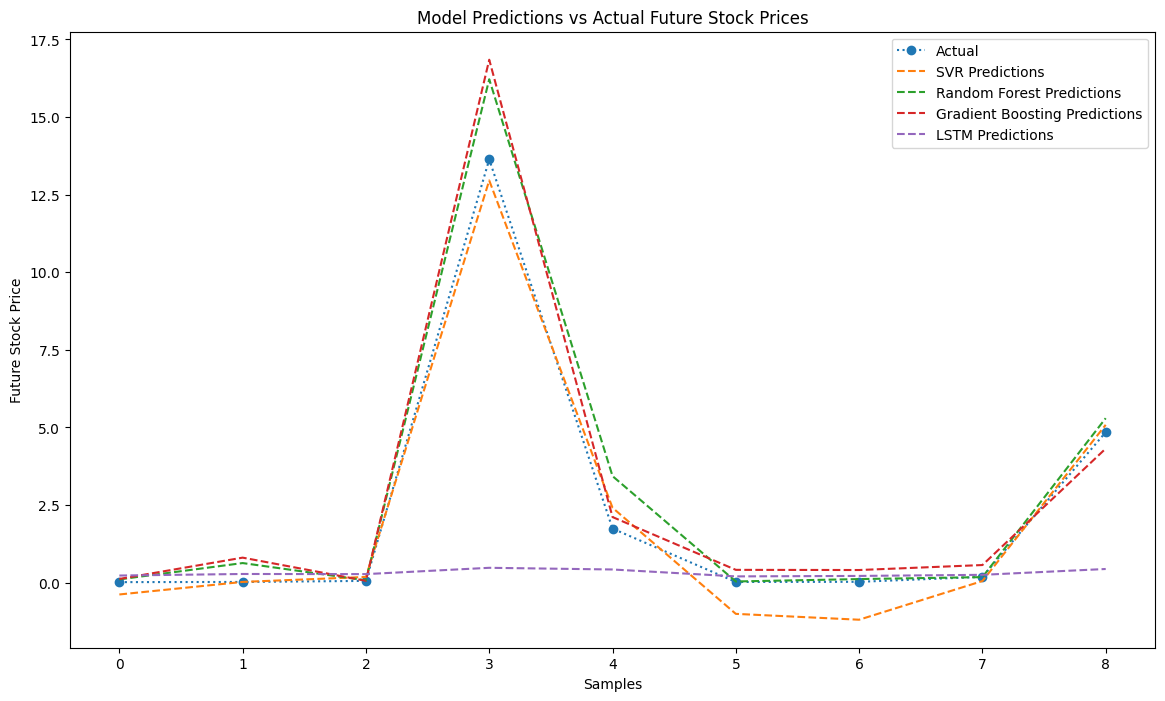

In [46]:
# Visualization of actual vs predicted for all models on the testing set
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label='Actual', linestyle='dotted', marker='o')
plt.plot(svr_test_pred, label='SVR Predictions', linestyle='--')
plt.plot(rf_test_pred, label='Random Forest Predictions', linestyle='--')
plt.plot(gbm_test_pred, label='Gradient Boosting Predictions', linestyle='--')
plt.plot(lstm_test_pred, label='LSTM Predictions', linestyle='--')
plt.title('Model Predictions vs Actual Future Stock Prices')
plt.xlabel('Samples')
plt.ylabel('Future Stock Price')
plt.legend()
plt.show()


In [47]:
pip install fastapi uvicorn joblib tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00


In [48]:
pip install python-multipart

In [49]:
from fastapi import FastAPI
import joblib
from tensorflow.keras.models import load_model
import numpy as np

# Initialize FastAPI app
app = FastAPI()

# Load trained models
svr_model = joblib.load("saved_models/svr_model.pkl")
rf_model = joblib.load("saved_models/random_forest_model.pkl")
gbm_model = joblib.load("saved_models/gbm_model.pkl")
lstm_model = load_model("saved_models/lstm_model.h5")

# Root endpoint
@app.get("/")
def read_root():
    return {"message": "Welcome to the Stock Prediction API!"}

# Predict endpoint for SVR
@app.post("/predict/svr")
def predict_svr(features: list):
    """
    Input: List of features [Stock_Price, Inflation, Interest_Rate, Sentiment_Score]
    Output: Predicted future stock price using SVR
    """
    prediction = svr_model.predict([features])
    return {"prediction": prediction[0]}

# Predict endpoint for Random Forest
@app.post("/predict/random_forest")
def predict_rf(features: list):
    """
    Input: List of features [Stock_Price, Inflation, Interest_Rate, Sentiment_Score]
    Output: Predicted future stock price using Random Forest
    """
    prediction = rf_model.predict([features])
    return {"prediction": prediction[0]}

# Predict endpoint for Gradient Boosting
@app.post("/predict/gbm")
def predict_gbm(features: list):
    """
    Input: List of features [Stock_Price, Inflation, Interest_Rate, Sentiment_Score]
    Output: Predicted future stock price using Gradient Boosting
    """
    prediction = gbm_model.predict([features])
    return {"prediction": prediction[0]}

# Predict endpoint for LSTM
@app.post("/predict/lstm")
def predict_lstm(features: list):
    """
    Input: List of features [Stock_Price, Inflation, Interest_Rate, Sentiment_Score]
    Output: Predicted future stock price using LSTM
    """
    # Ensure input is reshaped for LSTM
    reshaped_features = np.array(features).reshape(1, len(features), 1)
    prediction = lstm_model.predict(reshaped_features)
    return {"prediction": prediction[0][0]}


In [50]:
uvicorn app:app --reload


SyntaxError: invalid syntax (<ipython-input-50-7f5336593619>, line 1)

In [51]:
POST http://127.0.0.1:8000/predict/svr
Body: [300, 2.5, 1.5, 0.7]


SyntaxError: invalid syntax (<ipython-input-51-bb341865cc1b>, line 1)